# Supervised RPM

In [17]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.utils import shuffle as util_shuffle
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as torch_dist

In [49]:
# dataset generator
def normalize(x, mu, std):
    return (x - mu) / std

def sample_gaussian_mixture(num_samples, num_components=8):
    z = torch.randn(num_samples, 2)
    scale = 4
    sq2 = 1/np.sqrt(2)

    if num_components == 8:
        centers = [(1,0), (-1,0), (0,1), (0,-1), (sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
    else:
        centers = [(sq2,sq2), (-sq2,sq2), (sq2,-sq2), (-sq2,-sq2)]
    centers = torch.tensor([(scale * x, scale * y) for x,y in centers]).to(torch.float32)
    y = torch.arange(len(centers))

    sample_idx = torch.randint(len(centers), size=(num_samples,))

    x = sq2 * (0.5 * z + centers[sample_idx])
    y = y[sample_idx]
    return x, y

def make_moons(n_samples=100, *, shuffle=True, noise=0.05, random_state=None):
    np.random.seed(random_state)
    n_samples_out = n_samples // 2
    # n_samples_in = n_samples - n_samples_out

    z = np.linspace(0, np.pi, n_samples_out)

    outer_circ_x = np.cos(z)
    outer_circ_y = np.sin(z)
    inner_circ_x = 1 - np.cos(z)
    inner_circ_y = 1 - np.sin(z) - 0.5

    x = np.vstack(
        [np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y)]
    ).T
    z = np.append(z, z)
    z = np.stack([z, z[::-1]], axis=-1)
    z = normalize(z, z.mean(0), z.std(0))

    if shuffle:
        x, z = util_shuffle(x, z)

    if noise is not None:
        x += np.random.normal(scale=noise, size=x.shape)

    return x, z

## RPM

In [13]:
def cross_entropy(p, q, eps=1e-6):
    logq = torch.log(q + eps)
    ce = -torch.sum(p * logq, dim=-1)
    return ce

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        out = self.network(x)
        return out
    
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super().__init__()
        self.mlp = MLP(input_dim, output_dim * 2, hidden_dims)
    
    def forward(self, x):
        mu, ls = torch.chunk(self.mlp(x), 2, dim=-1)
        sd = ls.exp()
        return mu, sd
    
    def encode(self, x):
        mu, sd = self.forward(x)
        return torch_dist.Normal(mu, sd)
    
class RPMCont(nn.Module):
    """Continuous recognition parameterized model"""
    def __init__(
        self, 
        x_dim, 
        z_dim, 
        y_dim, 
        y_continuous,
        hidden_dims, 
        energy_func="f", 
        beta_1=1., 
        beta_2=0.3, 
        beta_3=0.2, 
        beta_4=0.,
    ):
        super().__init__()
        self.energy_func = energy_func
        self.y_continuous = y_continuous
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.beta_3 = beta_3
        self.beta_4 = beta_4

        if energy_func == "f":
            self.f = MLP(x_dim + z_dim, 1, hidden_dims)
        elif energy_func == "logp":
            self.f = GaussianEncoder(x_dim, z_dim, hidden_dims)
        
        self.encoder = GaussianEncoder(x_dim, z_dim, hidden_dims)
        self.linear = nn.Linear(z_dim, y_dim)
    
    def forward_f(self, x, z):
        f = self.f(torch.cat([x, z], dim=-1))

        sample_idx_neg = torch.randint(len(x), size=(50,)) # hard code number of negative samples
        x_neg = x[sample_idx_neg]
        x_neg_ = x_neg.unsqueeze(0).repeat_interleave(len(x), dim=0)
        z_ = z.unsqueeze(1).repeat_interleave(len(x_neg), dim=1)
        f_neg_ = self.f(torch.cat([x_neg_, z_], dim=-1))
        f_neg_ = torch.cat([f.unsqueeze(-2), f_neg_], dim=-2)
        
        # lse = torch.logsumexp(f_neg_, dim=-2)
        # logp = f - lse

        labels = torch.zeros_like(f_neg_.squeeze(-1))
        labels[:, 0] = 1
        p = torch.softmax(f_neg_.squeeze(-1), dim=-1)
        logp = -cross_entropy(labels, p)
        accuracy = torch.sum(p.argmax(-1) == labels.argmax(-1)) / len(p)        
        return logp, accuracy
    
    def forward_logp(self, x, z):
        z_dist = self.f.encode(x)

        # f = z_dist.log_prob(z).sum(-1)
        f_neg = z_dist.log_prob(z.unsqueeze(-2)).sum(-1)
        
        # lse = torch.logsumexp(f_neg, dim=-1)
        # logp = f - lse

        labels = torch.eye(len(x))
        p = torch.softmax(f_neg, dim=-1)
        logp = -cross_entropy(labels, p)
        accuracy = torch.sum(p.argmax(-1) == labels.argmax(-1)) / len(p)        
        return logp, accuracy
    
    def forward(self, x, z):
        """Compute log likelihood up to a constant for a batch"""
        if self.energy_func == "f":
            logp = self.forward_f(x, z)
        elif self.energy_func == "logp":
            logp = self.forward_logp(x, z)
        return logp
    
    def encode(self, x):
        mu, sd = self.encoder.forward(x)
        post = torch_dist.Normal(mu, sd)
        return post
    
    def compute_cov(self, z):
        """Compute representation covariance"""
        z_mean = z.mean(0, keepdim=True)
        z_res = z - z_mean
        cov = torch.sum(z_res.unsqueeze(-2) * z_res.unsqueeze(-1), dim=0) / (len(z_res) - 1)
        return cov
    
    def compute_cov_loss(self, cov):
        mask = (1 - torch.eye(len(cov)))
        loss = torch.sum(cov.abs() * mask) / mask.sum()
        return loss
    
    def compute_loss(self, x, y):
        """ELBO loss"""
        # e step
        post = self.encode(x)
        z = post.rsample()
        ent = post.entropy().sum(-1)
        
        # m step
        log_prior = torch_dist.Normal(torch.zeros(1), torch.ones(1)).log_prob(z).sum(-1)
        logp, accuracy = self.forward(x, z)
        loss = logp.mean() + self.beta_1 * log_prior.mean() + self.beta_2 * ent.mean()

        # reg
        cov = self.compute_cov(z)
        cov_loss = self.compute_cov_loss(cov)
        loss -= self.beta_3 * cov_loss

        # supervised loss
        if self.y_continuous:
            pred = z
            clf_loss = -torch.pow(pred - y, 2).mean()
        else:
            pred = torch.softmax(self.linear(z), dim=-1)
            clf_loss = -cross_entropy(y, pred).mean()
        loss += self.beta_4 * clf_loss

        stats = {
            "loss": -loss.data.mean().item(),
            "accuracy": accuracy.data.item(),
            "log_like_y": clf_loss.data.item(),
            "log_like": logp.data.mean().item(),
            "log_prior": log_prior.data.mean().item(),
            "ent": ent.data.mean().item(),
            "cov": cov_loss.data.item(),
        }
        return -loss, stats

In [34]:
def print_grads(model):
    for n, p in model.named_parameters():
        if p.grad is None:
            print(n, None)
        else:
            print(n, p.grad.data.norm())

def train(model, data, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    bar = tqdm(range(epochs))
    for e in bar:
        loss, stats = model.compute_loss(**data)

        optimizer.zero_grad()
        loss.backward()
        # print_grads(model)
        optimizer.step()

        bar.set_description(f"e: {e}, loss: {loss:.2f}")
        history.append(stats)
    history = pd.DataFrame(history)
    return model, history

def fit_rpm(x, y, y_continuous, beta=0.):
    # prep data
    if not isinstance(x, torch.Tensor):
        x = torch.from_numpy(x).to(torch.float32)
    if not isinstance(y, torch.Tensor):
        y = torch.from_numpy(y).to(torch.float32)

    if not y_continuous:
        y = F.one_hot(y.long(), num_classes=torch.unique(y).shape[-1])
        
    data = {"x": x.to(torch.float32), "y": y.to(torch.float32)}

    # init model
    x_dim = x.shape[-1]
    z_dim = 2
    y_dim = y.shape[-1]
    hidden_dims = [200, 200]
    model = RPMCont(
        x_dim, 
        z_dim, 
        y_dim,
        y_continuous,
        hidden_dims, 
        energy_func="f",
        beta_1=0.2,
        beta_2=0.2,
        beta_3=0.2,
        beta_4=beta,
    )

    lr = 1.e-3
    epochs = 1000
    model, df_history = train(model, data, epochs, lr)
    return model, df_history

## Data: 8 gaussian (discrete)

In [63]:
seed = 0
num_samples = 1000
x, y = sample_gaussian_mixture(num_samples)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed)

In [35]:
torch.manual_seed(0)

# train without supervision
y_continuous = False
rpm, df_history = fit_rpm(x_train, y_train, y_continuous, beta=0.)

# train with supervision
y_continuous = False
s_rpm, df_history_s = fit_rpm(x_train, y_train, y_continuous, beta=3.)

e: 999, loss: 1.57: 100%|██████████| 1000/1000 [00:37<00:00, 26.69it/s]


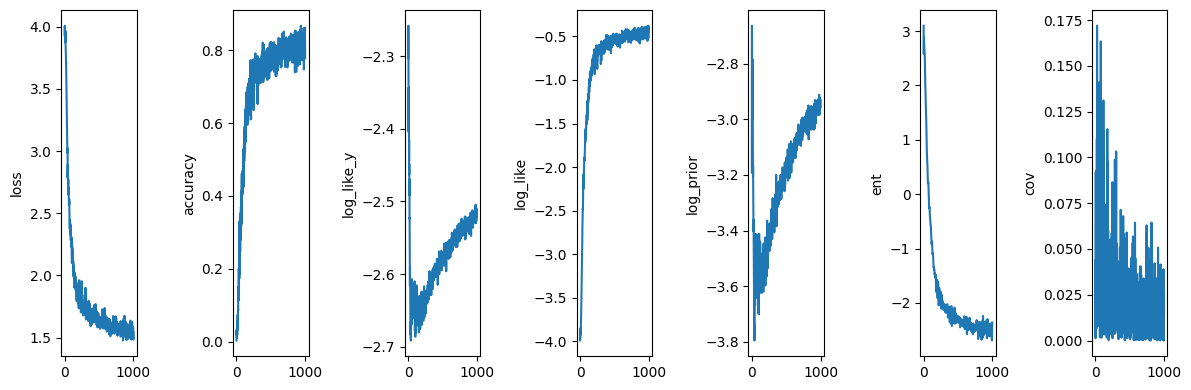

In [37]:
loss_keys = list(df_history.columns)
fig, ax = plt.subplots(1, len(loss_keys), figsize=(12, 4))
for i, k in enumerate(loss_keys):
    ax[i].plot(df_history[k])
    ax[i].set_label("epoch")
    ax[i].set_ylabel(k)
plt.tight_layout()
plt.show()

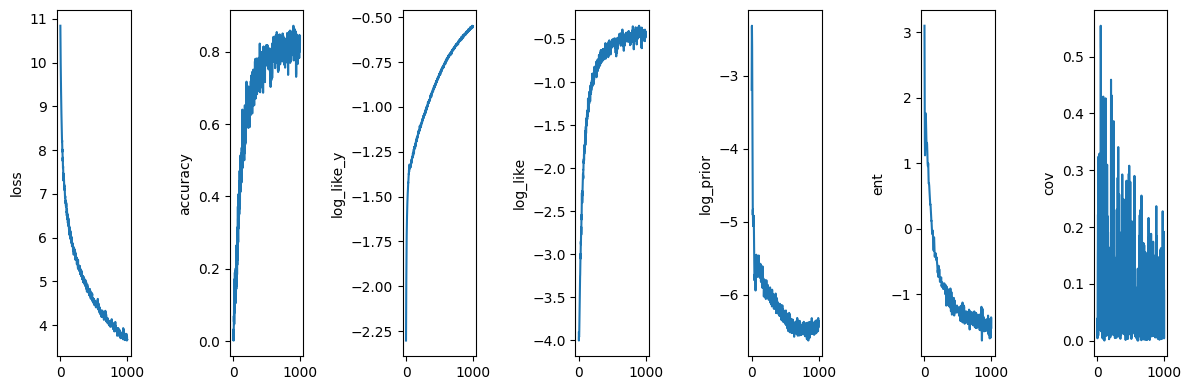

In [38]:
loss_keys = list(df_history.columns)
fig, ax = plt.subplots(1, len(loss_keys), figsize=(12, 4))
for i, k in enumerate(loss_keys):
    ax[i].plot(df_history_s[k])
    ax[i].set_label("epoch")
    ax[i].set_ylabel(k)
plt.tight_layout()
plt.show()

In [61]:
def plot_comparison(x, y, rpm_pred, srpm_pred):
    y_ = y.clone()
    if len(y.shape) > 1:
        y_ = y_[:, 0]
        
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    ax[0].scatter(x[:, 0], x[:, 1], c=y_)
    ax[0].set_title("data")

    ax[1].scatter(rpm_pred[:, 0], rpm_pred[:, 1], c=y_)
    ax[1].set_title("rpm projection")

    ax[2].scatter(srpm_pred[:, 0], srpm_pred[:, 1], c=y_)
    ax[2].set_title("supervised rpm projection")

    plt.tight_layout()
    plt.show()

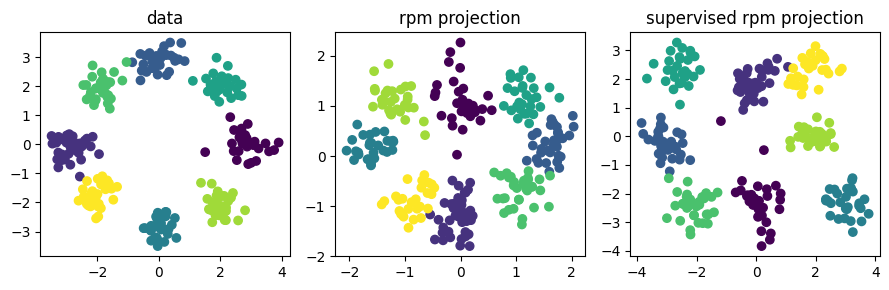

In [62]:
# visualize
with torch.no_grad():
    rpm_pred = rpm.encode(x_test).mean
    srpm_pred = s_rpm.encode(x_test).mean
    
plot_comparison(x_test, y_test, rpm_pred, srpm_pred)

## Data: 2 circles (discrete)

In [71]:
seed = 0
num_samples = 1000
x, y = make_circles(num_samples, factor=0.4, noise=0.05, random_state=seed)
x = torch.from_numpy(x).to(torch.float32)
y = torch.from_numpy(y).long()
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed)

In [73]:
torch.manual_seed(0)

# train without supervision
y_continuous = False
rpm, df_history = fit_rpm(x_train, y_train, y_continuous, beta=0.)

# train with supervision
y_continuous = False
s_rpm, df_history_s = fit_rpm(x_train, y_train, y_continuous, beta=3.)

e: 999, loss: 1.75: 100%|██████████| 1000/1000 [00:38<00:00, 26.26it/s]


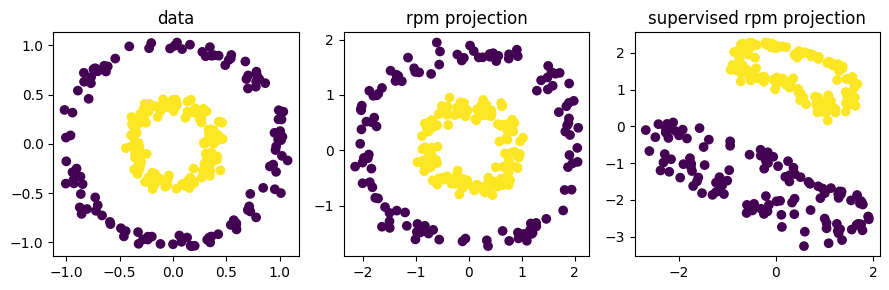

In [74]:
# visualize
with torch.no_grad():
    rpm_pred = rpm.encode(x_test).mean
    srpm_pred = s_rpm.encode(x_test).mean
    
plot_comparison(x_test, y_test, rpm_pred, srpm_pred)

## Data: 2 moons (continuous)

In [77]:
seed = 0
num_samples = 1000
x, y = make_moons(num_samples, random_state=seed)
x = torch.from_numpy(x).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed)

In [79]:
torch.manual_seed(0)

# train without supervision
y_continuous = True
rpm, df_history = fit_rpm(x_train, y_train, y_continuous, beta=0.)

# train with supervision
y_continuous = True
s_rpm, df_history_s = fit_rpm(x_train, y_train, y_continuous, beta=3.)

e: 999, loss: 2.13: 100%|██████████| 1000/1000 [00:37<00:00, 26.60it/s]


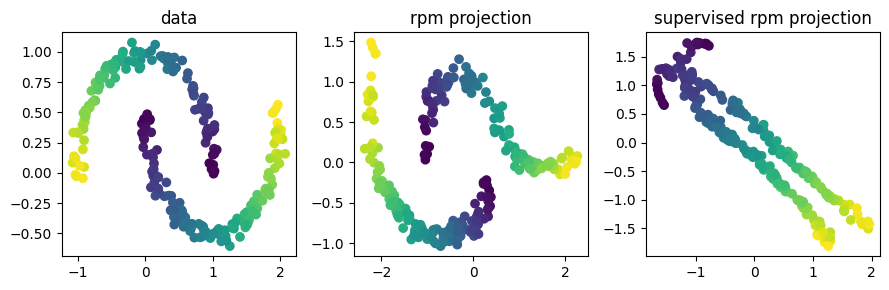

In [80]:
# visualize
with torch.no_grad():
    rpm_pred = rpm.encode(x_test).mean
    srpm_pred = s_rpm.encode(x_test).mean
     
plot_comparison(x_test, y_test, rpm_pred, srpm_pred)